cd OneDrive/Bureaublad/ARC/deep-multimodal-learning/mvae/Scripts/activate.bat

In [1]:
import torch
from functions import get_loader, plot_histories, plot_history
from functions_cae import train_cae, validate_cae, DeepCAE, SimpleCAE, SimpleCAE_Dropout, visualize_latent_space, visualize_reconstruction, get_latent_dataset
import torch.nn as nn
from functions_mlp import rawMLP, train_mlp, validate_mlp, caeMLP
import matplotlib.pyplot as plt

In [2]:
##### CONFIG
NUM_EPOCHS = 2
LR_RATE = 1e-3
BATCH_SIZE = 16
WEIGHT_DECAY = 1e-5

DEVICE = ""
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using GPU...")
else:
    DEVICE = torch.device("cpu")
    print("CUDA is not available. Using CPU...")

BASE_PATH = 'C:/Users/Frank/OneDrive/Bureaublad/ARC/deep-multimodal-learning/data_v2'

# Define the tool names and actions
TOOL_NAMES = ['hook', 'ruler', 'spatula', 'sshot']
ACTIONS = ['left_to_right', 'pull', 'push', 'right_to_left']

# All available object names
train_objects = ['0_woodenCube', '1_pearToy', '2_yogurtYellowbottle', '3_cowToy', '4_tennisBallYellowGreen',
            '5_blackCoinbag', '6_lemonSodaCan', '7_peperoneGreenToy', '8_boxEgg','9_pumpkinToy',
            '10_tomatoCan', '11_boxMilk']

val_objects = ['12_containerNuts', '13_cornCob', '14_yellowFruitToy',
            '15_bottleNailPolisher']

test_objects =['16_boxRealSense', '17_clampOrange', '18_greenRectangleToy', '19_ketchupToy']

CUDA is available. Using GPU...


In [3]:
train_loader = get_loader(BASE_PATH, train_objects, TOOL_NAMES, ACTIONS, "color", "training", batch_size=BATCH_SIZE)
val_loader = get_loader(BASE_PATH, val_objects, TOOL_NAMES, ACTIONS, "color", "validation", batch_size=BATCH_SIZE)
test_loader = get_loader(BASE_PATH, test_objects, TOOL_NAMES, ACTIONS, "color", "testing", batch_size=BATCH_SIZE)

Epoch [1/2], Loss: 0.6554
Average PSNR Epoch [1/2]:, Loss: 18.1373
Average SSIM Epoch [1/2]:, Loss: 0.4844


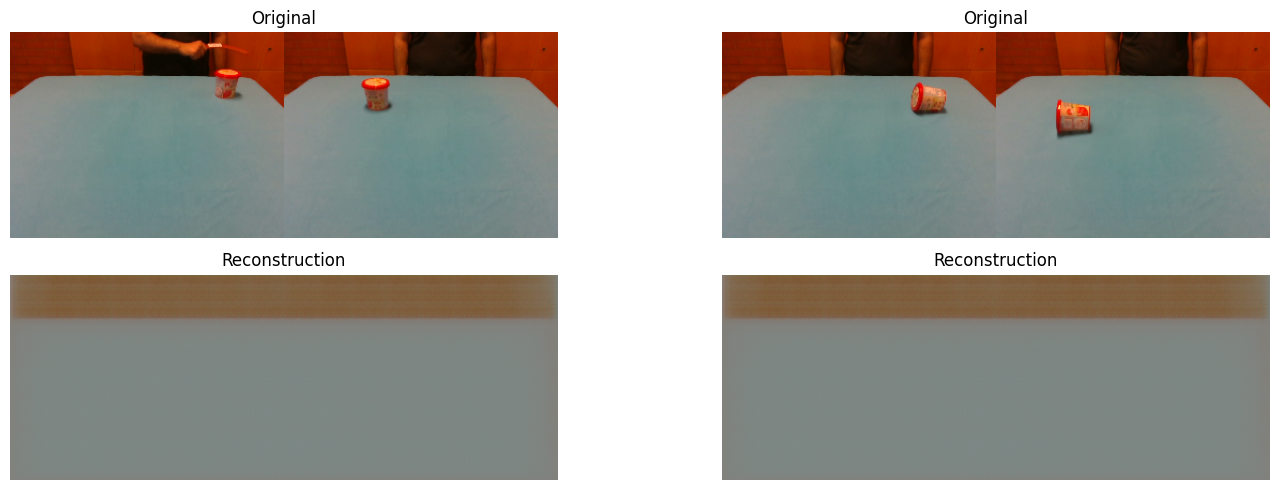

Epoch [2/2], Loss: 0.6307
Average PSNR Epoch [2/2]:, Loss: 20.7527
Average SSIM Epoch [2/2]:, Loss: 0.6786


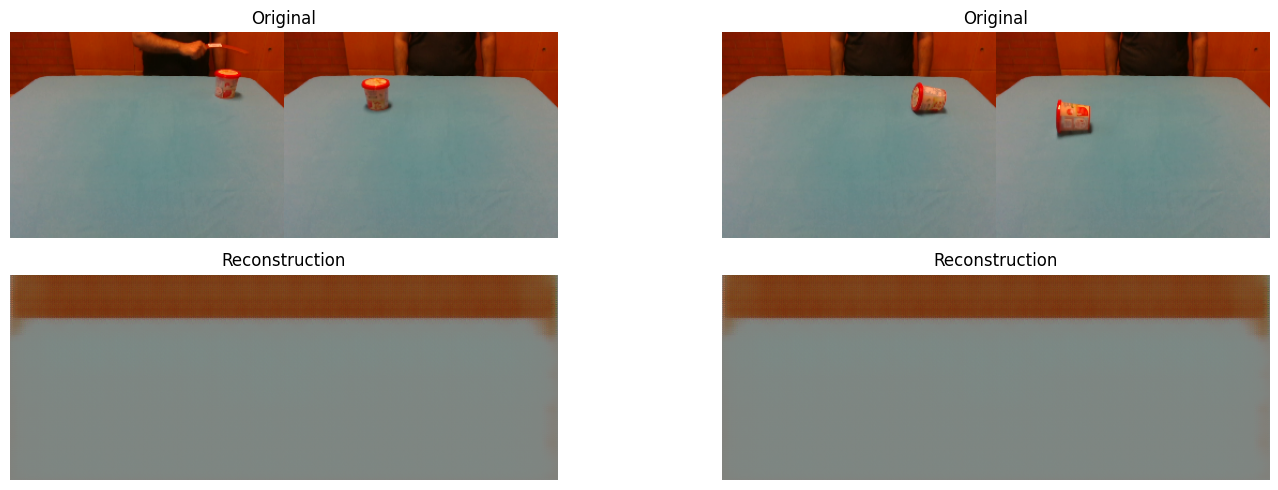

Average Validation Loss: 0.6421095341444015
Average PSNR: 19.773078574480806
Average PSNR: 0.6464070422205103


In [4]:
# cae_lossfunction = nn.MSELoss()
cae_lossfunction = nn.BCELoss()

# Training loop
#cae = SimpleCAE().to(DEVICE)
#cae = SimpleCAE_Dropout().to(DEVICE)
cae = DeepCAE().to(DEVICE)
cae_optimizer_adam = torch.optim.Adam(cae.parameters(), lr=LR_RATE)
cae_optimizer_sgd = torch.optim.SGD(cae.parameters(), lr=LR_RATE, momentum=0.9)
cae_optimizer_adamw = torch.optim.AdamW(cae.parameters(), lr=LR_RATE, weight_decay=1e-2)

trained_cae, cae_batch_loss_history, cae_epoch_loss_history = train_cae(cae, val_loader, cae_lossfunction, cae_optimizer_adam, NUM_EPOCHS, True, DEVICE)
avg_val_loss, cae_validation_loss_history = validate_cae(trained_cae, test_loader, cae_lossfunction, DEVICE)

In [8]:
# Config MLP
mlp_lossfunction = nn.CrossEntropyLoss()  # Loss function
output_dim = 4 
NUM_EPOCHS = 5
LR_RATE = 1e-3

# Extract features from the train and validation sets
train_dataset = get_latent_dataset(trained_cae, val_loader)
val_dataset = get_latent_dataset(trained_cae, test_loader)

# Create DataLoaders for the extracted features
mlp_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mlp_val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize
input_dim = train_dataset[:][0].size(1)
mlp = caeMLP(input_dim, output_dim).to(DEVICE)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr=LR_RATE)

# Train the model
trained_mlp, mlp_epoch_avg_losses, mlp_epoch_accuracy = train_mlp(mlp, mlp_lossfunction, mlp_optimizer, mlp_train_loader, NUM_EPOCHS, DEVICE)

# Validate the model
validate_mlp(mlp, mlp_lossfunction, mlp_val_loader, DEVICE)

Epoch [1/5], Train Loss: 3.4504, Train Acc: 0.32
Epoch [2/5], Train Loss: 0.9314, Train Acc: 0.59
Epoch [3/5], Train Loss: 0.7764, Train Acc: 0.68
Epoch [4/5], Train Loss: 0.6615, Train Acc: 0.72
Epoch [5/5], Train Loss: 0.7132, Train Acc: 0.69
Val Loss: 0.0131, Val Acc: 0.96


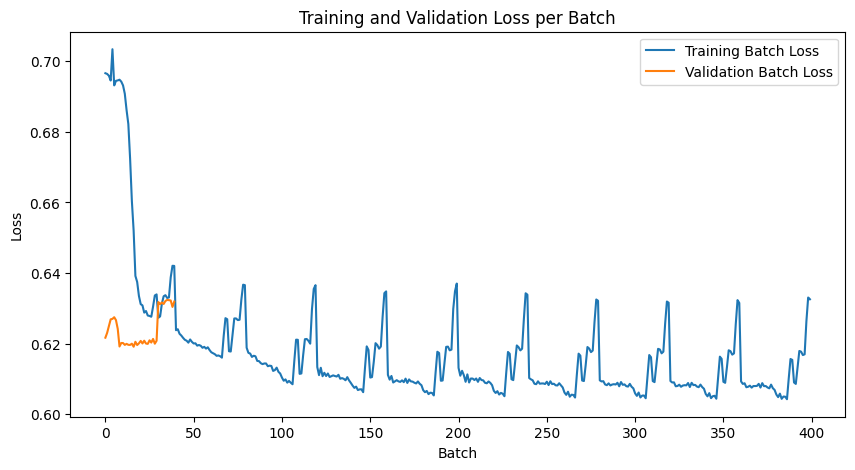

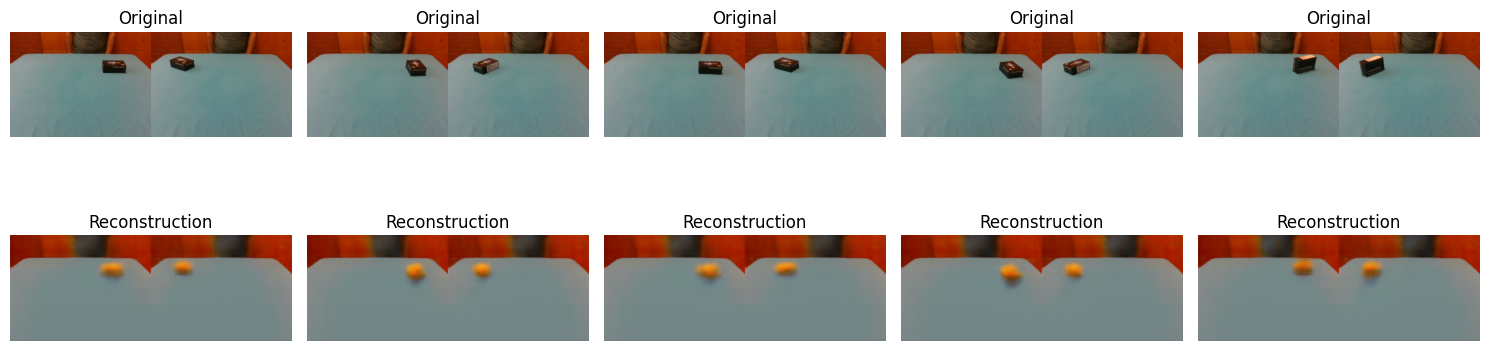

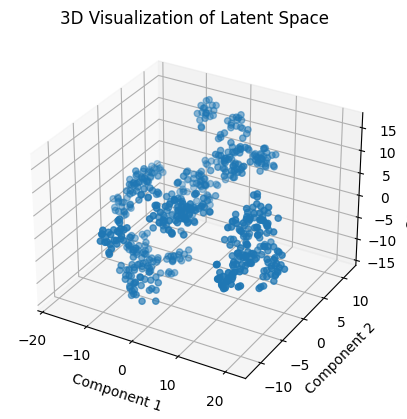

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


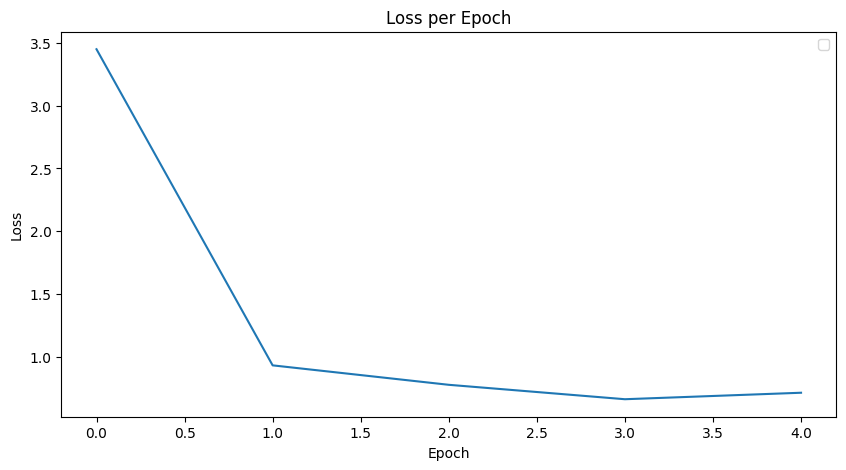

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


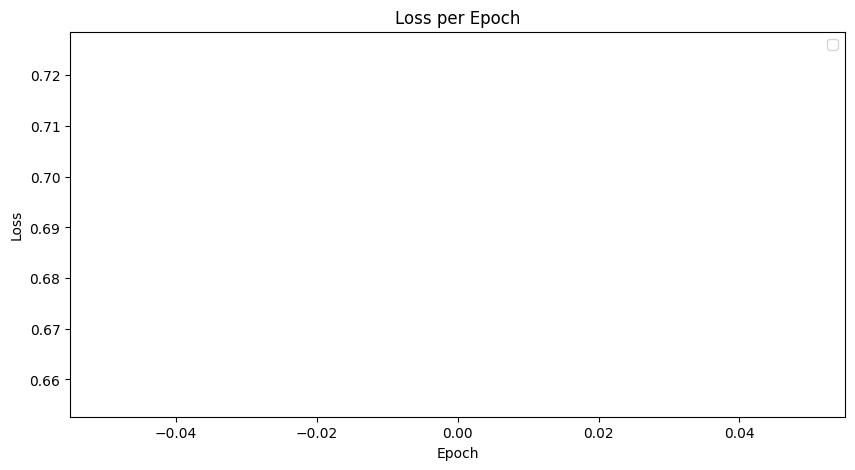

In [9]:
plot_histories(cae_batch_loss_history, cae_validation_loss_history)
visualize_reconstruction(trained_cae, test_loader, num_samples=5)
visualize_latent_space(trained_cae, test_loader, n_components=3)
plot_history(mlp_epoch_avg_losses)
plot_history(mlp_epoch_accuracy)

In [ ]:
"early_stopping" after some epochs no improvements.
"superimpose"